####1. Importing Libraries

In [1]:
# General Libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub


# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50, VGG19, MobileNet
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# for Images
import cv2
import random

####2. Importing dataset

In [2]:
# Download latest version
path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")

print("Path to dataset files:", path)

100%|██████████| 612M/612M [00:06<00:00, 93.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1


####3. Checking Dataset



#####i.  Check for missing or corrupted data.



In [3]:
# Paths to the metadata files
train_csv_path = '/root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1'
test_csv_path = '/root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1'

# Load the metadata into DataFrames
train_df = pd.read_csv(os.path.join(train_csv_path, "Train.csv"))
test_df = pd.read_csv(os.path.join(train_csv_path, "Test.csv"))


# Display basic dataset info
print(train_df.info())  # Column details of train.csv

print(train_df.describe())  # Statistical summary of train.csv

# Preview the first few rows
print("Training Data:")
print(train_df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39209 entries, 0 to 39208
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Width    39209 non-null  int64 
 1   Height   39209 non-null  int64 
 2   Roi.X1   39209 non-null  int64 
 3   Roi.Y1   39209 non-null  int64 
 4   Roi.X2   39209 non-null  int64 
 5   Roi.Y2   39209 non-null  int64 
 6   ClassId  39209 non-null  int64 
 7   Path     39209 non-null  object
dtypes: int64(7), object(1)
memory usage: 2.4+ MB
None
              Width        Height        Roi.X1        Roi.Y1        Roi.X2  \
count  39209.000000  39209.000000  39209.000000  39209.000000  39209.000000   
mean      50.835880     50.328930      5.999515      5.962381     45.197302   
std       24.306933     23.115423      1.475493      1.385440     23.060157   
min       25.000000     25.000000      0.000000      5.000000     20.000000   
25%       35.000000     35.000000      5.000000      5.000000     29.000

#####ii. Checking duplicates

In [4]:
# Check for missing values in train.csv
print(train_df.isnull().sum())

Width      0
Height     0
Roi.X1     0
Roi.Y1     0
Roi.X2     0
Roi.Y2     0
ClassId    0
Path       0
dtype: int64


#**T1 DATA ANALYSIS**

####3. Exploratory Data Analysis (EDA)



#####i. Class Distribution
-Visualize the distribution of traffic signs.

-Identify if the dataset is imbalanced.


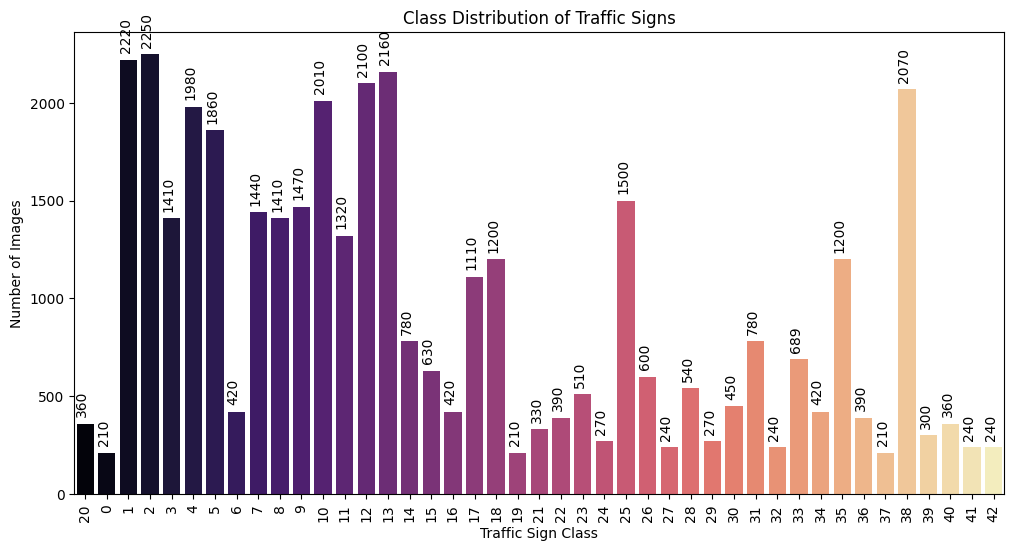

In [5]:
# Ensure 'ClassId' exists and has no NaN values
if 'ClassId' in train_df.columns and train_df['ClassId'].notna().any():
    plt.figure(figsize=(12, 6))
    ax = sns.countplot(x=train_df['ClassId'].astype(str), hue=train_df['ClassId'].astype(str), palette="magma", legend=False)

    # Adding count labels
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/3, height + 50, f'{int(height)}', ha="center", rotation=90)

    plt.title("Class Distribution of Traffic Signs")
    plt.xlabel("Traffic Sign Class")
    plt.ylabel("Number of Images")
    plt.xticks(rotation=90)
    plt.show()
else:
    print("Error: 'ClassId' column is missing or empty in the dataset.")


#####ii. Image Analysis

-Plot a few images with labels.

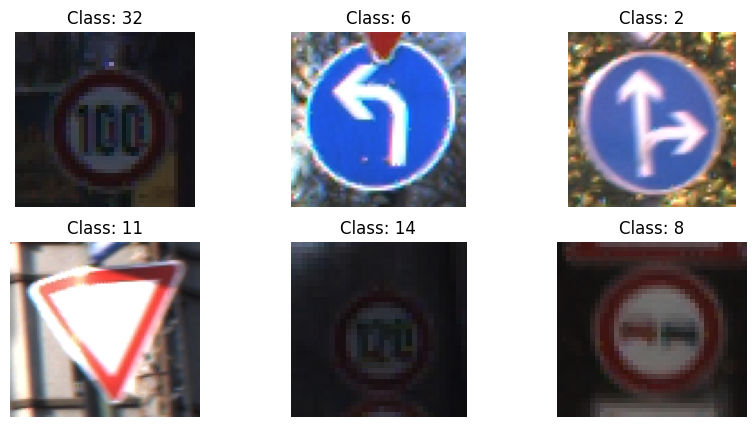

In [6]:
# Load and display random images
plt.figure(figsize=(10, 5))
for i in range(6):
    DATA_PATH = "/root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1"
    df = pd.read_csv(os.path.join(DATA_PATH, "Train.csv"))

    img_path = os.path.join(DATA_PATH, df.iloc[random.randint(0, len(df)-1)]['Path'])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    label = df.iloc[random.randint(0, len(df)-1)]['ClassId']

    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.title(f"Class: {label}")
    plt.axis('off')

plt.show()


#####iii. Displaying the brightness of the images using histogram


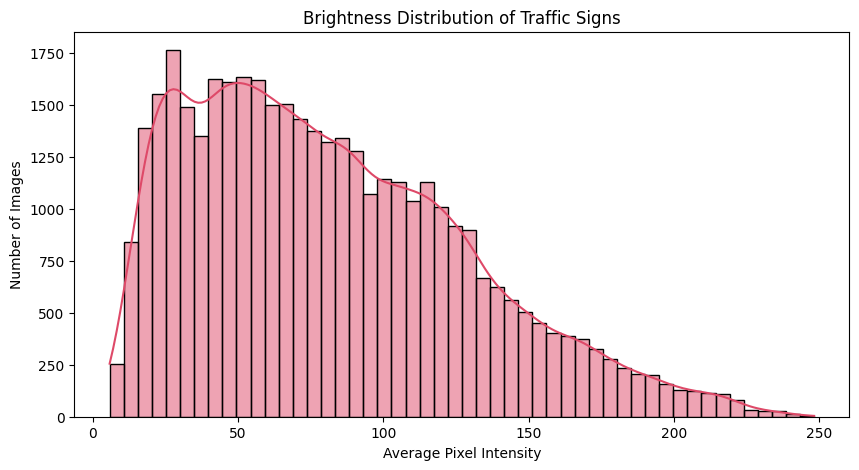

In [17]:
brightness = []
for _, row in df.iterrows():
    img_path = os.path.join(DATA_PATH, row['Path'])
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale
    brightness.append(np.mean(img))  # Mean pixel intensity


# Plot distribution
plt.figure(figsize=(10, 5))
sns.histplot(brightness, bins=50, kde=True, color="#de4968")
plt.title("Brightness Distribution of Traffic Signs")
plt.xlabel("Average Pixel Intensity")
plt.ylabel("Number of Images")
plt.show()


#####iv. Contrast Analysis

- Low contrast → Close to 0 (faded images).
- High contrast → Close to 1 (sharp images).

<ipython-input-8-2f98b9874d7a>:15: RuntimeWarning: overflow encountered in scalar add
  michelson_contrast = (I_max - I_min) / (I_max + I_min) if (I_max + I_min) != 0 else 0


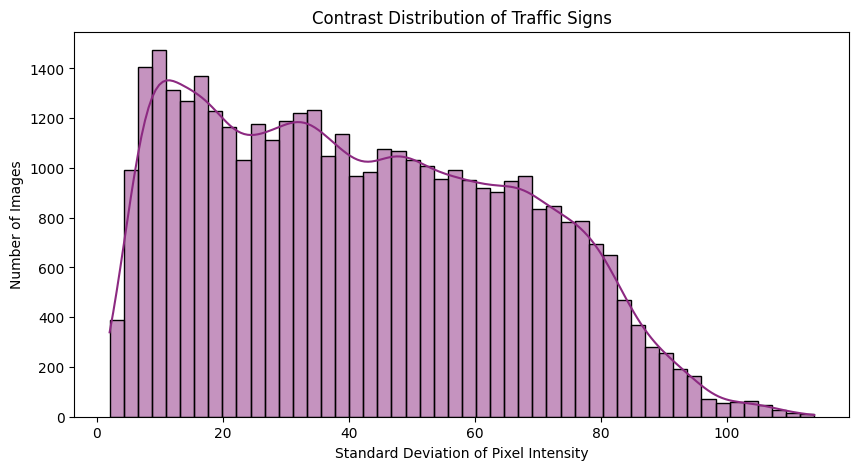

In [8]:
#iv. contrast analysis
contrast_values = []

for _, row in df.iterrows():
    img_path = os.path.join(DATA_PATH, row['Path'])
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale

    if img is None:
        continue

    # Compute Michelson Contrast
    I_max = np.max(img)  # Maximum pixel intensity
    I_min = np.min(img)  # Minimum pixel intensity

    michelson_contrast = (I_max - I_min) / (I_max + I_min) if (I_max + I_min) != 0 else 0

    # Compute Standard Deviation of Pixel Intensity
    std_dev_contrast = np.std(img)

    contrast_values.append(std_dev_contrast)  # Store standard deviation

# Plot contrast distribution
plt.figure(figsize=(10, 5))
sns.histplot(contrast_values, bins=50, kde=True, color="#8c2981")
plt.title("Contrast Distribution of Traffic Signs")
plt.xlabel("Standard Deviation of Pixel Intensity")
plt.ylabel("Number of Images")
plt.show()


####4. Summary Statistics

#####i. Mean and Standard Deviation of Pixel Values

- Useful for normalization before training.

In [9]:
# Calculate mean and std of pixel values across all images
pixel_means = []
pixel_stds = []

for _, row in df.iterrows():
    img_path = os.path.join(DATA_PATH, row['Path'])
    img = cv2.imread(img_path) / 255.0  # Normalize to [0,1]

    pixel_means.append(np.mean(img, axis=(0, 1)))  # Per-channel mean
    pixel_stds.append(np.std(img, axis=(0, 1)))  # Per-channel std dev

# Compute overall mean and std
mean_pixel_values = np.mean(pixel_means, axis=0)
std_pixel_values = np.mean(pixel_stds, axis=0)

print("Mean Pixel Values (R, G, B):", mean_pixel_values)
print("Std Dev Pixel Values (R, G, B):", std_pixel_values)


Mean Pixel Values (R, G, B): [0.32141543 0.31212966 0.34023045]
Std Dev Pixel Values (R, G, B): [0.17848932 0.16829375 0.16802703]


#####ii. What is Aspect Ratio?

**Aspect Ratio = Width of Image / Height of Image**

- Distorted images may be too stretched or squished, affecting how the model learns shapes.

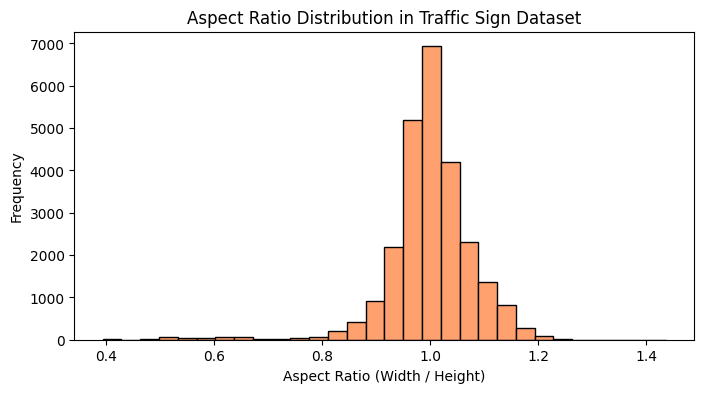

In [10]:
def analyze_aspect_ratios(DATA_PATH):
    aspect_ratios = []

    for class_folder in os.listdir(DATA_PATH):
        class_path = os.path.join(DATA_PATH, class_folder)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                img = cv2.imread(img_path)

                if img is None:
                    continue

                h, w, _ = img.shape  # Get image dimensions
                aspect_ratio = w / h  # Compute aspect ratio
                aspect_ratios.append(aspect_ratio)

    # Plot aspect ratio distribution
    plt.figure(figsize=(8, 4))
    plt.hist(aspect_ratios, bins=30, color='#fea16e', edgecolor='black')
    plt.xlabel("Aspect Ratio (Width / Height)")
    plt.ylabel("Frequency")
    plt.title("Aspect Ratio Distribution in Traffic Sign Dataset")
    plt.show()

# Example usage
analyze_aspect_ratios(DATA_PATH)  # Update with dataset path

####5. Outlier detection



######i. Size Based Outliers

In [11]:
Q1 = df['Width'].quantile(0.25)
Q3 = df['Width'].quantile(0.75)
IQR = Q3 - Q1  # Interquartile Range

# Define outlier range
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Detect outliers
outliers = df[(df['Width'] < lower_bound) | (df['Width'] > upper_bound)]
print("Outliers:\n", outliers)

Q1 = df['Height'].quantile(0.25)
Q3 = df['Height'].quantile(0.75)
IQR = Q3 - Q1  # Interquartile Range

# Define outlier range
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Detect outliers
outliers = df[(df['Height'] < lower_bound) | (df['Height'] > upper_bound)]
print("Outliers:\n", outliers)

Outliers:
        Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
26        97      87       8       7      89      80       20   
27       111     100       9       8     102      92       20   
28       131     119      12      11     120     109       20   
29       166     152      15      14     152     139       20   
89       105      99      10       8      96      91       20   
...      ...     ...     ...     ...     ...     ...      ...   
38817    117     128      10      11     107     117       41   
38818    131     144      11      13     120     132       41   
38938     96      98       8       9      88      89       41   
39027    105      99      10       9      96      91       42   
39028    124     118      11      10     114     108       42   

                                 Path  
26     Train/20/00020_00000_00026.png  
27     Train/20/00020_00000_00027.png  
28     Train/20/00020_00000_00028.png  
29     Train/20/00020_00000_00029.png  
89     T

######ii. Brightness Based Outlier

Found 7780 dark images and 386 overexposed images.


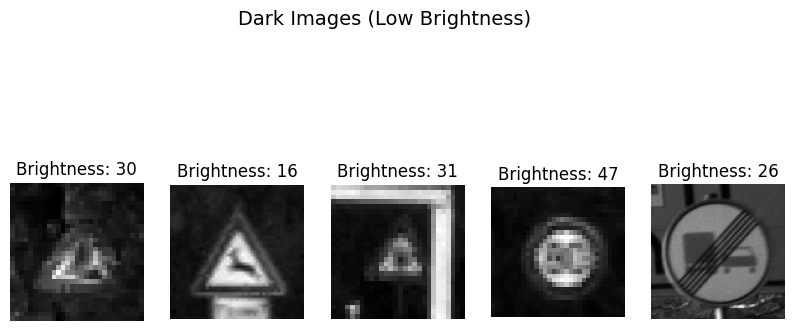

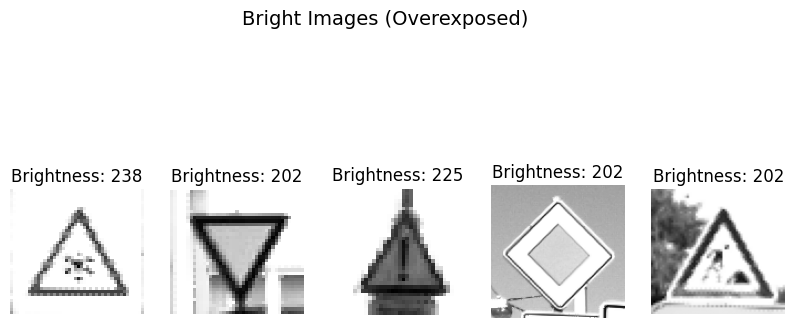

In [12]:
def detect_brightness_outliers(DATA_PATH, min_brightness=50, max_brightness=200):
    bright_outliers = []
    dark_outliers = []

    for class_folder in os.listdir(DATA_PATH):
        class_path = os.path.join(DATA_PATH, class_folder)
        if os.path.isdir(class_path):  # Ensure it's a folder
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale

                if img is None:
                    continue

                mean_brightness = np.mean(img)  # Compute brightness

                # Check for brightness-based outliers
                if mean_brightness < min_brightness:
                    dark_outliers.append((img_path, mean_brightness))
                elif mean_brightness > max_brightness:
                    bright_outliers.append((img_path, mean_brightness))

    print(f"Found {len(dark_outliers)} dark images and {len(bright_outliers)} overexposed images.")
    return dark_outliers, bright_outliers

# Example usage
dark_outliers, bright_outliers = detect_brightness_outliers(DATA_PATH)

# Function to display images
def display_images(image_list, title, num_images=5):
    plt.figure(figsize=(10, 5))
    for i, (img_path, brightness) in enumerate(image_list[:num_images]):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load in grayscale
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f'Brightness: {int(brightness)}')
        plt.axis('off')

    plt.suptitle(title, fontsize=14)
    plt.show()

# Display dark and bright outlier images
display_images(dark_outliers, "Dark Images (Low Brightness)")
display_images(bright_outliers, "Bright Images (Overexposed)")


####6. Feature Analysis

######i. Edge Detection
- Understanding important traffic sign features.

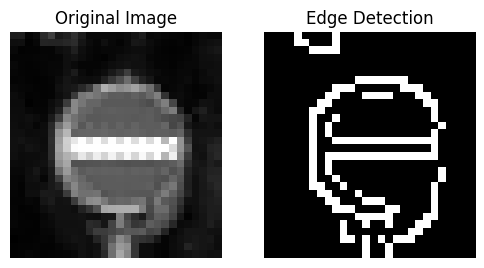

In [13]:
def edge_detection_example(PATH):
    img_path = os.path.join(DATA_PATH, df.iloc[random.randint(0, len(df)-1)]['Path'])
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    edges = cv2.Canny(img, 100, 200)  # Apply Canny edge detection

    plt.figure(figsize=(6, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(edges, cmap='gray')
    plt.title("Edge Detection")
    plt.axis("off")

    plt.show()

# Example usage
edge_detection_example("PATH")

####7. Image Size Distribution
- Since images in GTSRB have varying sizes, analyzing their distribution can help decide resizing parameters.

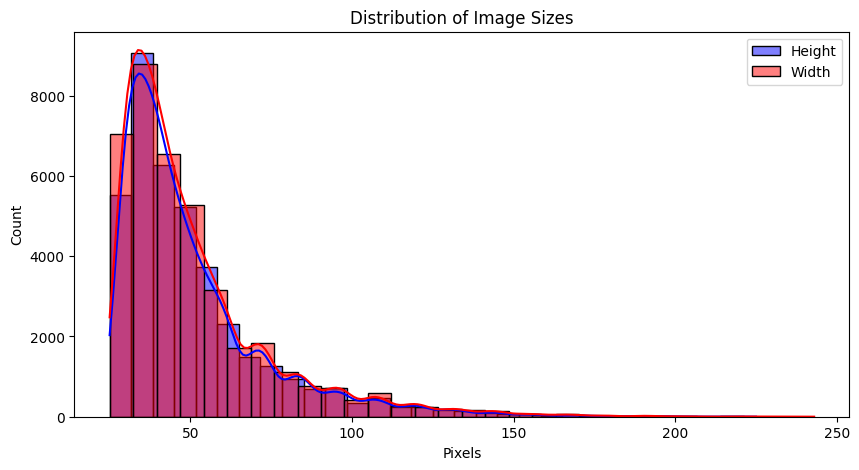

In [14]:
image_sizes = []
for _, row in df.iterrows():
    img_path = os.path.join(DATA_PATH, row['Path'])  # Path to each image
    img = cv2.imread(img_path)
    if img is not None:
        image_sizes.append(img.shape[:2])  # Store (height, width)

# Convert to DataFrame
sizes_df = pd.DataFrame(image_sizes, columns=['Height', 'Width'])

# Plot distribution
plt.figure(figsize=(10, 5))
sns.histplot(sizes_df['Height'], bins=30, kde=True, color='blue', label="Height")
sns.histplot(sizes_df['Width'], bins=30, kde=True, color='red', label="Width")
plt.legend()
plt.title("Distribution of Image Sizes")
plt.xlabel("Pixels")
plt.ylabel("Count")
plt.show()



####8. Occlusion Analysis (Blur Detection)

Some images may be blurry due to motion. Here we are using the Laplacian variance method.

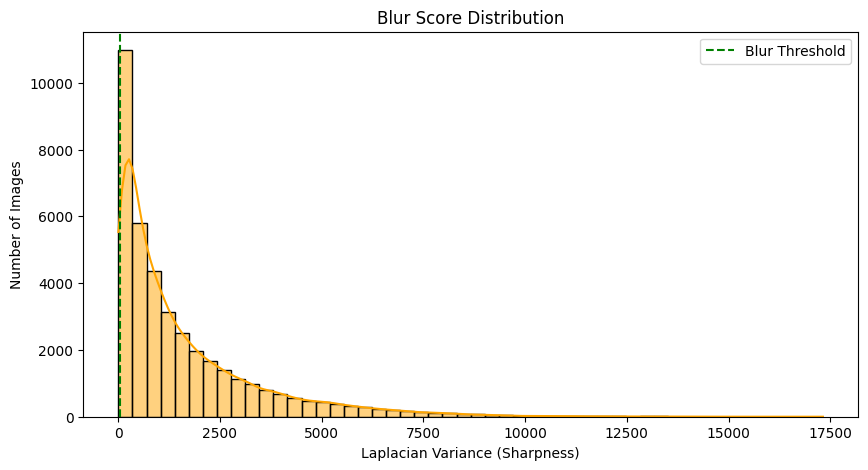

In [15]:
def detect_blur(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    variance = cv2.Laplacian(img, cv2.CV_64F).var()
    return variance  # Low variance → blurry image

blur_scores = [detect_blur(os.path.join(DATA_PATH, row['Path'])) for _, row in df.iterrows()]

# Plot blur score distribution
plt.figure(figsize=(10, 5))
sns.histplot(blur_scores, bins=50, kde=True, color="orange")
plt.axvline(x=50, color='green', linestyle="--", label="Blur Threshold")
plt.title("Blur Score Distribution")
plt.xlabel("Laplacian Variance (Sharpness)")
plt.ylabel("Number of Images")
plt.legend()
plt.show()


####9. Color Analysis

Traffic signs have specific colors (red, blue, yellow, white). Analyzing color distribution can help feature extraction.

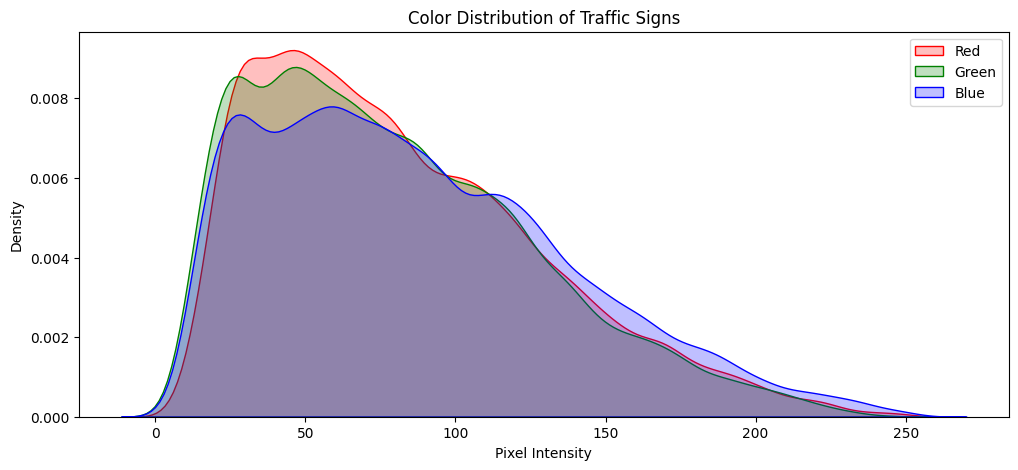

In [16]:
def get_dominant_color(image_path):
    img = cv2.imread(image_path)
    avg_color = np.mean(img, axis=(0, 1))  # Average (R, G, B)
    return avg_color

colors = np.array([get_dominant_color(os.path.join(DATA_PATH, row['Path'])) for _, row in df.iterrows()])
colors_df = pd.DataFrame(colors, columns=['Red', 'Green', 'Blue'])

# Plot color distribution
plt.figure(figsize=(12, 5))
sns.kdeplot(colors_df['Red'], color="red", label="Red", fill=True)
sns.kdeplot(colors_df['Green'], color="green", label="Green", fill=True)
sns.kdeplot(colors_df['Blue'], color="blue", label="Blue", fill=True)
plt.legend()
plt.title("Color Distribution of Traffic Signs")
plt.xlabel("Pixel Intensity")
plt.ylabel("Density")
plt.show()


#**T2 PRE-PROCESSING**

####1. Data Cleaning

- remove corrupted, blurry, or irrelevant images.
- removing duplication

####2.  Data Integration
- We don't need to do this step as the data comes from single source.

####3. DATA TRANFORMATION

- Resizing Images
- Normalization
- Contrast Enhancement
- Augmentation
- Label encoding - class labels are usually already numeric (0-42), so label encoding might not be necessary. However, if our dataset contains textual class names, this step ensures that they are converted into a format suitable for model training.

######i. Resizing Images

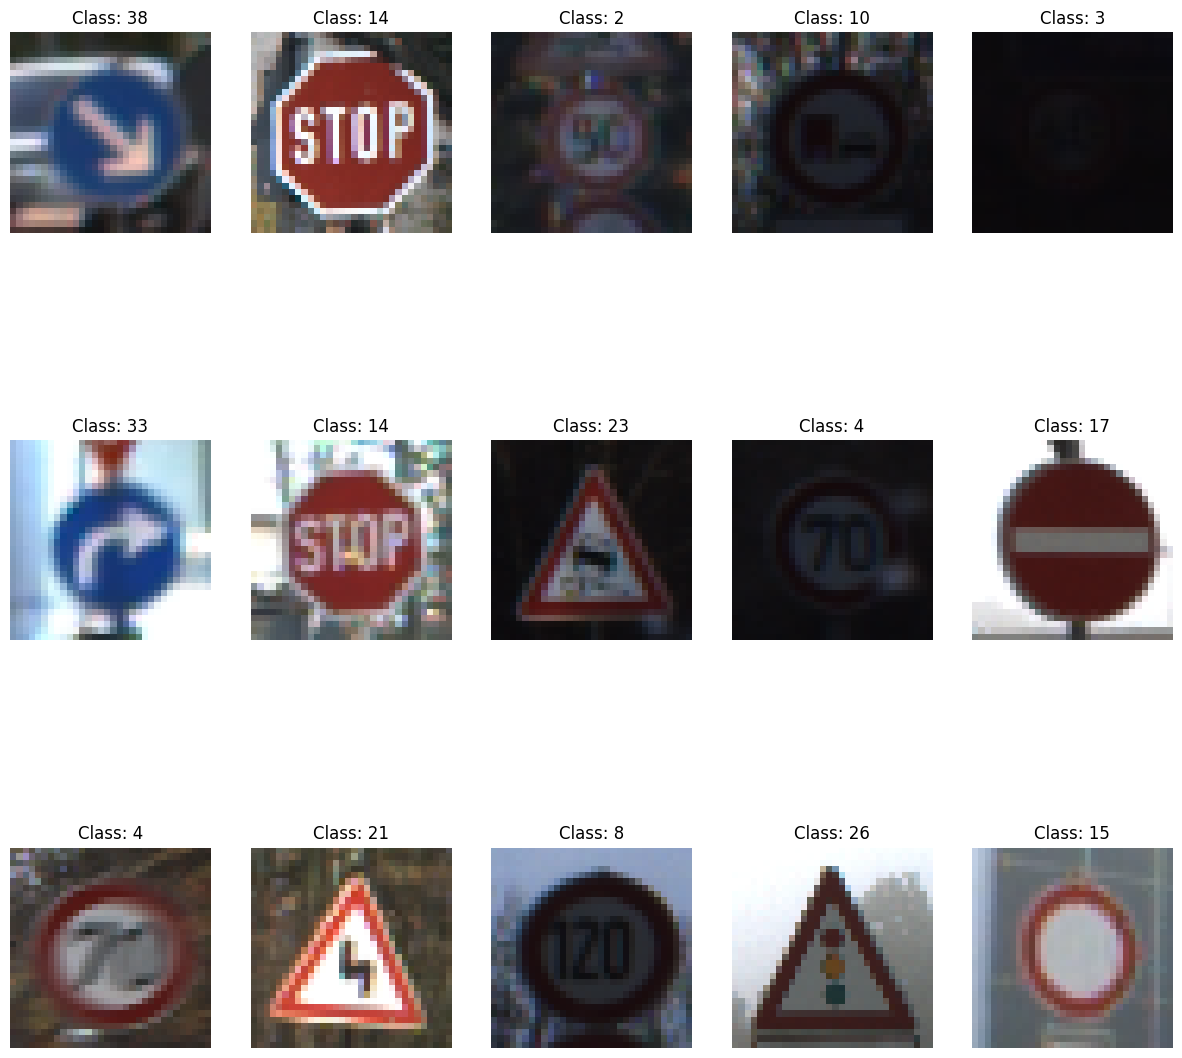

(32, 32, 3)


In [18]:
# Initialize lists for images and labels
X, y = [], []

# Iterate through dataset and load images
for index, row in df.iterrows():
    img_path = os.path.join(DATA_PATH, row['Path'])  # Ensure column name matches CSV
    image = cv2.imread(img_path)

    if image is None:
        print(f"Warning: Unable to read image {img_path}")
        continue  # Skip if image is missing

    image = cv2.resize(image, (32, 32))  # Resize if needed
    X.append(image)
    y.append(row['ClassId'])  # Ensure correct column name for labels

# Convert lists to NumPy arrays
X = np.array(X)
y = np.array(y)

# Function to display random images with labels
def display_random_images(images, labels, num_images=15):
    num_images_to_display = min(num_images, len(images))  # Ensure enough images are available
    random_indices = np.random.choice(len(images), num_images_to_display, replace=False)

    plt.figure(figsize=(15, 15))
    for i, idx in enumerate(random_indices):
        plt.subplot(3, 5, i + 1)  # Arrange in 3x5 grid
        plt.imshow(cv2.cvtColor(images[idx], cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
        plt.title(f"Class: {labels[idx]}")  # Display class label
        plt.axis('off')

    plt.show()

# Display 15 random images
display_random_images(X, y, num_images=15)
print (image.shape)

#####ii. Normalization

In [19]:
def normalize_images(image):
    """
    Normalize pixel values to [0, 1] range

    Args:
    - images: Input images

    Returns:
    - Normalized images
    """
    # Divide by 255.0 to scale values between 0 and 1
    normalized = image / 255.0
    return normalized

#####iii. Grayscale Conversion

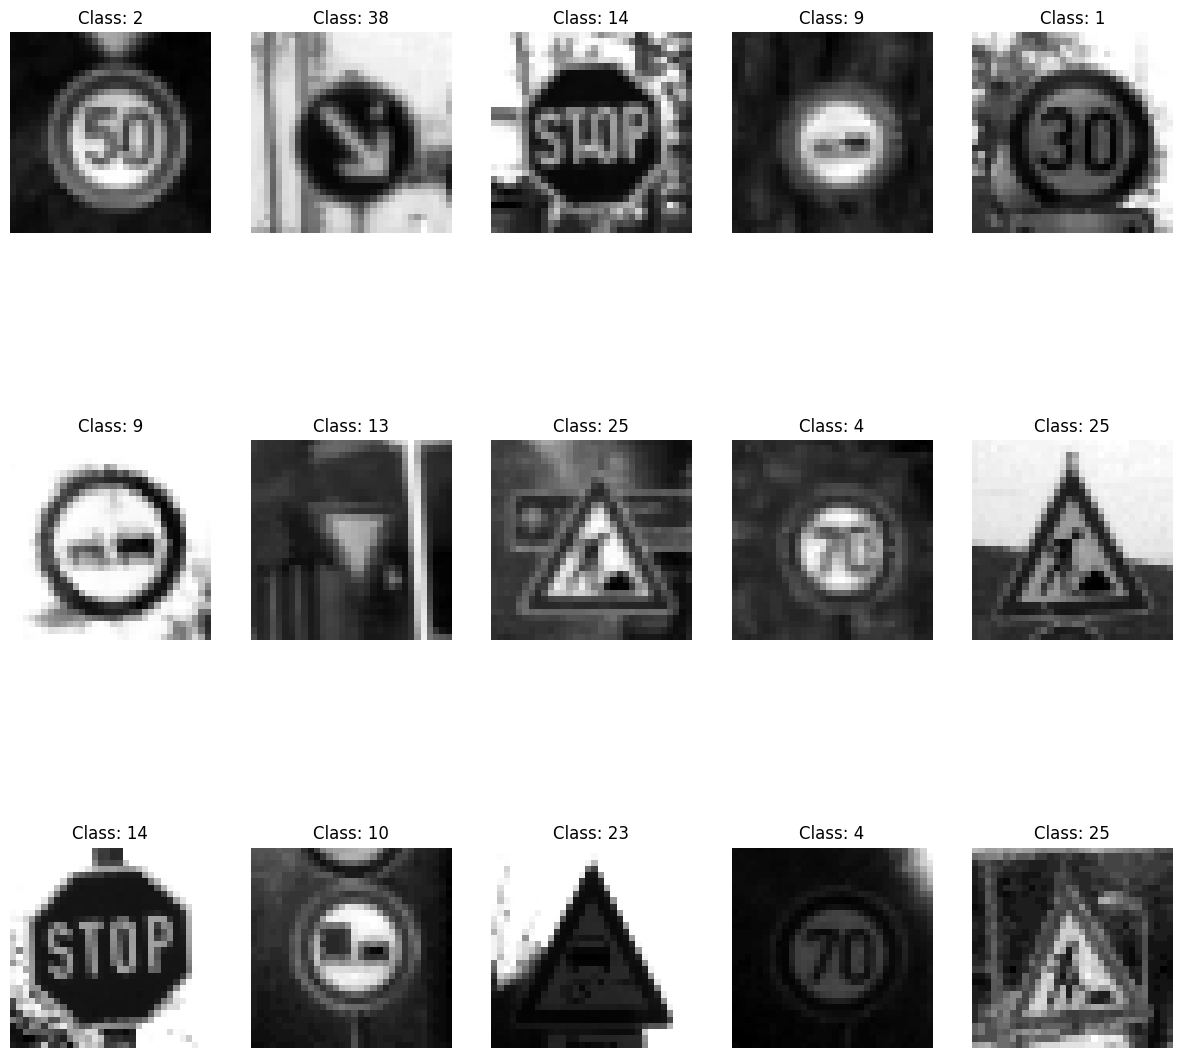

In [20]:
# Function to convert images to grayscale
def convert_to_grayscale(images):
    grayscale_images = []
    for image in images:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert BGR to grayscale
        grayscale_images.append(gray)
    return np.array(grayscale_images)

# Function to display random grayscale images
def display_random_images(images, labels, num_images=15):
    num_images_to_display = min(num_images, len(images))  # Ensure enough images are available
    random_indices = np.random.choice(len(images), num_images_to_display, replace=False)

    plt.figure(figsize=(15, 15))
    for i, idx in enumerate(random_indices):
        plt.subplot(3, 5, i + 1)  # Arrange in 3x5 grid
        plt.imshow(images[idx], cmap='gray')  # Display grayscale images
        plt.title(f"Class: {labels[idx]}")  # Display class label
        plt.axis('off')

    plt.show()

# Convert to grayscale
grayscale_images = convert_to_grayscale(X)

# Display 15 random grayscale images
display_random_images(grayscale_images, y, num_images=15)

#####iv. Contrast Enhancement

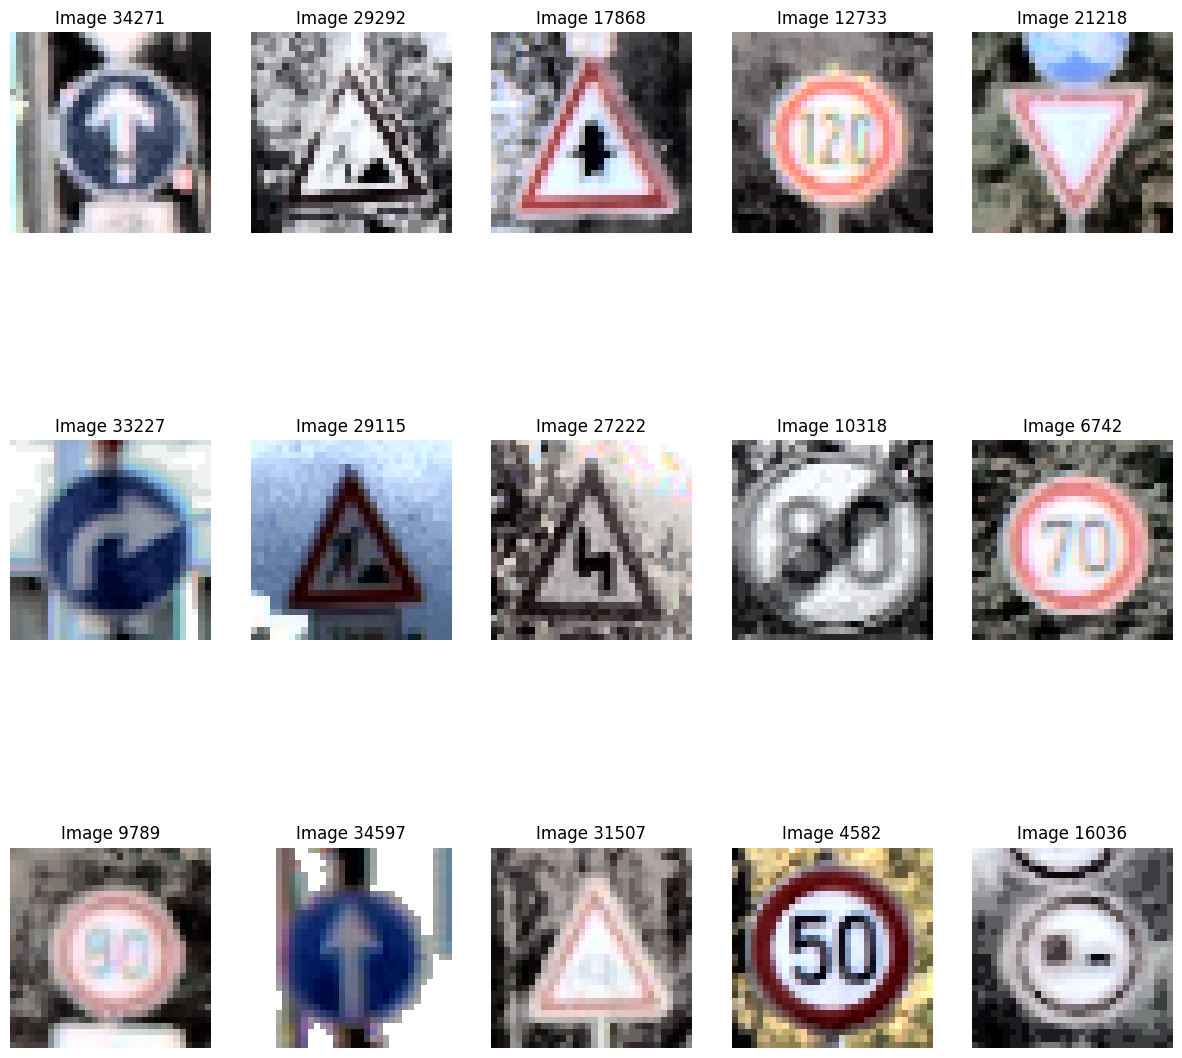

In [21]:
# Function to enhance contrast using histogram equalization
def enhance_contrast(images):
    """
    Enhance image contrast using histogram equalization

    Args:
    - images: Input images (can be color or grayscale)

    Returns:
    - Contrast-enhanced images
    """
    enhanced_images = []
    for image in images:
        # Check if image is grayscale or color
        if len(image.shape) == 2:
            # Grayscale histogram equalization
            equalized = cv2.equalizeHist(image)
        else:
            # Convert to YUV color space
            image_yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)

            # Equalize the luminance channel
            image_yuv[:,:,0] = cv2.equalizeHist(image_yuv[:,:,0])

            # Convert back to BGR
            equalized = cv2.cvtColor(image_yuv, cv2.COLOR_YUV2BGR)

        enhanced_images.append(equalized)

    return np.array(enhanced_images)

# Function to display random images
def display_random_images(images, num_images=15):
    random_indices = np.random.choice(len(images), num_images, replace=False)
    plt.figure(figsize=(15, 15))
    for i, idx in enumerate(random_indices):
        plt.subplot(3, 5, i + 1)  # Arrange images in a 3x5 grid
        plt.imshow(cv2.cvtColor(images[idx], cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for proper display
        plt.title(f"Image {idx}")
        plt.axis('off')  # Hide axes
    plt.show()
enhanced_images = enhance_contrast(X)

display_random_images(enhanced_images, num_images=15)

#### FUNCTIONS FOR PREPROCESSING
- This also contain splitting of training dataset into validation and training.



In [22]:
# Define constants
IMG_HEIGHT, IMG_WIDTH = 32, 32  # Standard size for CNNs
NUM_CLASSES = 43  # Total number of traffic sign classes

# Thresholds
BLUR_THRESHOLD = 100  # Laplacian variance threshold for blurriness
OVEREXPOSURE_THRESHOLD = 220  # Bright pixels threshold
UNDEREXPOSURE_THRESHOLD = 50  # Dark pixels threshold

# Preprocessing functions as provided
def detect_image_issues(image):
    """
    Detects if an image is blurry, overexposed, or underexposed.
    Returns a list of detected issues.
    """
    issues = []
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # 1️⃣ Check for blurriness using Laplacian variance
    laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()
    if laplacian_var < BLUR_THRESHOLD:
        issues.append("blurry")

    # 2️⃣ Check for overexposure (too many bright pixels)
    bright_pixels = np.mean(gray)
    if bright_pixels > OVEREXPOSURE_THRESHOLD:
        issues.append("overexposed")

    # 3️⃣ Check for underexposure (too many dark pixels)
    if bright_pixels < UNDEREXPOSURE_THRESHOLD:
        issues.append("underexposed")

    return issues

def deblur_image(image):
    """
    Deblurs the image using Wiener deconvolution.
    This function assumes the image is blurry and tries to restore the details.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Unsharp Masking technique
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])  # A simple unsharp mask
    deblurred_image = cv2.filter2D(gray, -1, kernel)

    deblurred_image_bgr = cv2.cvtColor(deblurred_image, cv2.COLOR_GRAY2BGR)

    return deblurred_image_bgr

def enhance_image(image, issues):
    """
    Enhances the image based on detected issues.
    Applies sharpening, brightness correction, and contrast adjustment.
    """
    enhanced_image = image.copy()

    if "blurry" in issues:
        enhanced_image = deblur_image(enhanced_image)

    if "blurry" in issues:
        kernel = np.array([[0, -0.5, 0],
                           [-0.5, 3, -0.5],
                           [0, -0.5, 0]])  # Sharpening filter
        enhanced_image = cv2.filter2D(enhanced_image, -1, kernel)

    if "overexposed" in issues:
        enhanced_image = cv2.convertScaleAbs(enhanced_image, alpha=1.2, beta=-10)  # Reduce brightness slightly
    elif "underexposed" in issues:
        enhanced_image = cv2.convertScaleAbs(enhanced_image, alpha=1.2, beta=10)  # Increase brightness slightly

    enhanced_image = improve_resolution(enhanced_image)

    return enhanced_image

def improve_resolution(image):
    """
    Improve the resolution of the image using bicubic interpolation.
    """
    height, width = image.shape[:2]
    new_dimensions = (width * 2, height * 2)  # Double the resolution

    improved_image = cv2.resize(image, new_dimensions, interpolation=cv2.INTER_CUBIC)

    return improved_image

def load_and_preprocess_data(DATA_PATH, df, img_size=(32, 32)):
    images = []
    labels = []

    # Loop over the dataframe to load the images and labels
    for idx, row in df.iterrows():
        img_path = os.path.join(DATA_PATH, row['Path'])
        img = cv2.imread(img_path)

        if img is not None:
            # Detect issues and enhance image
            issues = detect_image_issues(img)
            enhanced_img = enhance_image(img, issues)

            # Resize the image to 32x32
            img_resized = cv2.resize(enhanced_img, img_size)

            # Normalize the image
            img_resized = img_resized.astype('float32') / 255.0  # Normalize to [0, 1]

            images.append(img_resized)
            labels.append(row['ClassId'])  # Assuming 'Label' is the column with the class labels

    images = np.array(images)
    labels = np.array(labels)

    # One-hot encode labels if necessary (optional)
    # labels = keras.utils.to_categorical(labels, num_classes=10)

    # Split data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

    return X_train, X_val, y_train, y_val

# Load the data
DATA_PATH = "/root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1"
df = pd.read_csv(os.path.join(DATA_PATH, "Train.csv"))
X_train, X_val, y_train, y_val = load_and_preprocess_data(DATA_PATH, df)


# Load training images and labels
X_train_paths = [os.path.join(DATA_PATH, path) for path in train_df['Path']]
X_train, _, y_train, _ = load_and_preprocess_data(DATA_PATH, train_df) # Pass both DATA_PATH and train_df to the function

# One-hot encode labels
y_train = to_categorical(y_train, NUM_CLASSES)

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print("Training Data Shape:", X_train.shape)
print("Validation Data Shape:", X_val.shape)

Training Data Shape: (25093, 32, 32, 3)
Validation Data Shape: (6274, 32, 32, 3)


######Function to plot sample images

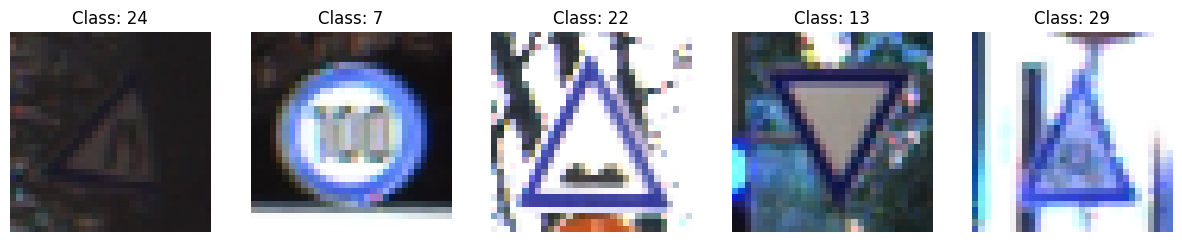

In [23]:
# Function to plot sample images
def plot_sample_images(data, labels, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i in range(num_samples):
        idx = random.randint(0, len(data) - 1)
        axes[i].imshow(data[idx])
        axes[i].set_title(f"Class: {np.argmax(labels[idx])}")
        axes[i].axis('off')
    plt.show()

# Plot sample training images
plot_sample_images(X_train, y_train)

#**T3 IMPLEMENTATION**

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

def evaluate_model(model, X_test, y_test):
    """
    Evaluate the model on test data and print test accuracy, loss, precision, recall, and F1-score.

    Args:
        model: Trained Keras model.
        X_test: Test data (numpy array).
        y_test: True labels (one-hot encoded numpy array).
    """
    # Calculate test accuracy and loss
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

    # Get model predictions
    y_pred_probs = model.predict(X_test)
    y_pred = y_pred_probs.argmax(axis=1)  # Convert probabilities to class labels
    y_true = y_test.argmax(axis=1)  # Convert one-hot encoding to class labels

    # Print classification report
    print("Classification Report:\n", classification_report(y_true, y_pred, digits=4))

    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
    print(f"Test Loss: {test_loss:.4f}")

def plot_training_curves(history):
    """
    Plot training and validation loss/accuracy curves.

    Args:
        history: History object returned by model.fit().
    """
    # Extract metrics from history
    acc = history.history.get('accuracy', [])
    val_acc = history.history.get('val_accuracy', [])
    loss = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    if val_acc:
        plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    if val_loss:
        plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

###Models

####i. CNN MODEL

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the model with an explicit Input layer
cnn_aug = Sequential([
    Input(shape=(32, 32, 3)),  # Explicit Input layer
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(43, activation='softmax')  # 43 classes
])

# Compile the model
cnn_aug.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# Print model summary
cnn_aug.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 43)                  │          11,051 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 235,627 (920.42 KB)

 Trainable params: 235,627 (920.42 KB)

 Non-trainable params: 0 (0.00 B)

##### Data Agumentation for CNN

In [26]:
# Define data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,       # Randomly rotate images by up to 10 degrees
    width_shift_range=0.1,   # Randomly shift images horizontally by 10%
    height_shift_range=0.1,  # Randomly shift images vertically by 10%
    zoom_range=0.2,          # Randomly zoom in on images by up to 20%
    fill_mode='nearest'      # Fill missing pixels after transformations
)

# Fit the generator on the training data
datagen.fit(X_train)

In [28]:
# Define callbacks for early stopping and learning rate reduction
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

train_generator = datagen.flow(X_train, y_train, batch_size=64, shuffle=True)

history_2 = cnn_aug.fit(
    train_generator,
    validation_data=(X_val, y_val),
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)




Epoch 1/20
393/393 ━━━━━━━━━━━━━━━━━━━━ 55s 140ms/step - accuracy: 0.2159 - loss: 2.7741 - val_accuracy: 0.6195 - val_loss: 1.2420 - learning_rate: 0.0010
Epoch 2/20
393/393 ━━━━━━━━━━━━━━━━━━━━ 51s 129ms/step - accuracy: 0.5848 - loss: 1.3169 - val_accuracy: 0.8548 - val_loss: 0.4799 - learning_rate: 0.0010
Epoch 3/20
393/393 ━━━━━━━━━━━━━━━━━━━━ 55s 141ms/step - accuracy: 0.7462 - loss: 0.7971 - val_accuracy: 0.9179 - val_loss: 0.2719 - learning_rate: 0.0010
Epoch 4/20
393/393 ━━━━━━━━━━━━━━━━━━━━ 53s 134ms/step - accuracy: 0.8304 - loss: 0.5329 - val_accuracy: 0.9468 - val_loss: 0.1936 - learning_rate: 0.0010
Epoch 5/20
393/393 ━━━━━━━━━━━━━━━━━━━━ 52s 133ms/step - accuracy: 0.8720 - loss: 0.4131 - val_accuracy: 0.9500 - val_loss: 0.1627 - learning_rate: 0.0010
Epoch 6/20
393/393 ━━━━━━━━━━━━━━━━━━━━ 53s 134ms/step - accuracy: 0.8928 - loss: 0.3386 - val_accuracy: 0.9708 - val_loss: 0.1117 - learning_rate: 0.0010
Epoch 7/20
393/393 ━━━━━━━━━━━━━━━━━━━━ 49s 124ms/step - accuracy: 0.9

#####Saving the CNN Model

In [29]:
cnn_aug.save('/content/Models/cnn_aug_model.h5')
print("Model saved at: /content/cnn_aug_model.h5")

Model saved at: /content/cnn_aug_model.h5


#####Evaluating CNN model

In [30]:
evaluate_model(cnn_aug, X_val, y_val)

197/197 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9900 - loss: 0.0304
197/197 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
Classification Report:
               precision    recall  f1-score   support

           0     0.9722    1.0000    0.9859        35
           1     0.9862    0.9808    0.9835       364
           2     0.9885    0.9857    0.9871       349
           3     0.9910    0.9822    0.9866       225
           4     0.9804    0.9901    0.9852       303
           5     0.9763    0.9931    0.9846       290
           6     0.9861    1.0000    0.9930        71
           7     0.9871    0.9705    0.9787       237
           8     0.9817    0.9907    0.9862       216
           9     0.9953    0.9953    0.9953       214
          10     0.9968    0.9935    0.9952       310
          11     0.9771    0.9907    0.9838       215
          12     1.0000    1.0000    1.0000       326
          13     1.0000    1.0000    1.0000       378
          14     1.0000    1.0000    1.0000    

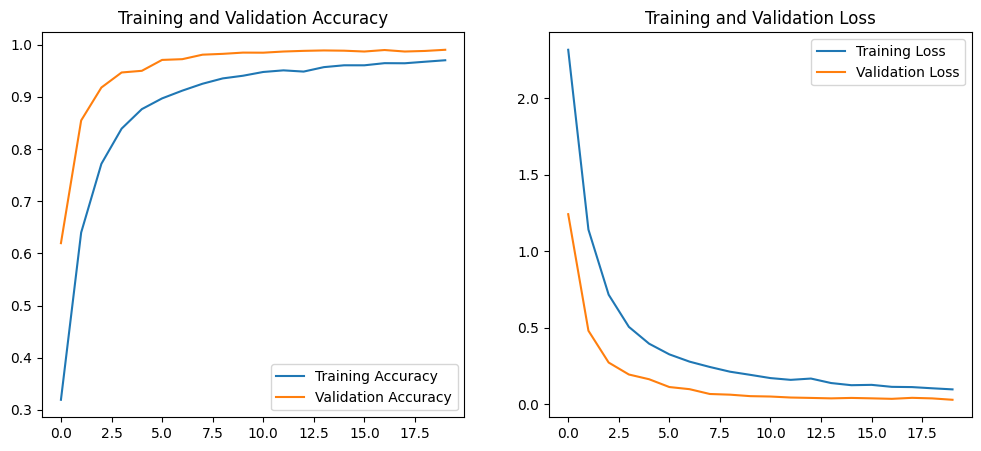

In [31]:
plot_training_curves(history_2)

####ii. LeNet model

In [32]:
# Define LeNet architecture
def create_lenet(input_shape=(32, 32, 3), num_classes=43):
    model = Sequential([
        Input(shape=input_shape),  # ✅ Define input layer explicitly

        # Block 1
        Conv2D(6, kernel_size=(5, 5), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        # Block 2
        Conv2D(16, kernel_size=(5, 5), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        # Fully Connected Layers
        Flatten(),
        Dense(120, activation='relu'),
        Dense(84, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Create and summarize the model
lenet_model = create_lenet()
lenet_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 6)           │             456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 6)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 10, 10, 16)          │           2,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 5, 5, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 400)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 120)                 │          48,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 84)                  │          10,164 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 84)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 43)                  │           3,655 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 64,811 (253.17 KB)

 Trainable params: 64,811 (253.17 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
# Define callbacks for early stopping and learning rate reduction
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model with original data
history_lenet_initial = lenet_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 30s 32ms/step - accuracy: 0.3025 - loss: 2.6186 - val_accuracy: 0.8315 - val_loss: 0.6369 - learning_rate: 0.0010
Epoch 2/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step - accuracy: 0.7693 - loss: 0.7633 - val_accuracy: 0.9227 - val_loss: 0.3001 - learning_rate: 0.0010
Epoch 3/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 39s 26ms/step - accuracy: 0.8724 - loss: 0.4333 - val_accuracy: 0.9484 - val_loss: 0.1896 - learning_rate: 0.0010
Epoch 4/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.9100 - loss: 0.3068 - val_accuracy: 0.9525 - val_loss: 0.1777 - learning_rate: 0.0010
Epoch 5/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 40s 26ms/step - accuracy: 0.9288 - loss: 0.2327 - val_accuracy: 0.9719 - val_loss: 0.1096 - learning_rate: 0.0010
Epoch 6/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step - accuracy: 0.9493 - loss: 0.1774 - val_accuracy: 0.9653 - val_loss: 0.1244 - learning_rate: 0.0010
Epoch 7/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 40s 27ms/step - accuracy: 0.9508 - l

####Saving Lenet Model

In [34]:
lenet_model.save('/content/Models/lenet_model.h5')
print("Model saved at: /content/lenet_model.h5")

Model saved at: /content/lenet_model.h5


#####Evaluating LeNet Model

In [35]:
# Evaluate the model
evaluate_model(lenet_model, X_val, y_val)

197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9872 - loss: 0.0696
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Classification Report:
               precision    recall  f1-score   support

           0     1.0000    0.9429    0.9706        35
           1     0.9837    0.9973    0.9905       364
           2     0.9914    0.9914    0.9914       349
           3     0.9735    0.9778    0.9756       225
           4     0.9900    0.9835    0.9868       303
           5     0.9662    0.9862    0.9761       290
           6     1.0000    0.9577    0.9784        71
           7     0.9745    0.9662    0.9703       237
           8     0.9816    0.9861    0.9838       216
           9     0.9905    0.9720    0.9811       214
          10     0.9935    0.9903    0.9919       310
          11     0.9907    0.9953    0.9930       215
          12     0.9908    0.9939    0.9923       326
          13     0.9974    0.9974    0.9974       378
          14     1.0000    0.9917    0.9958      

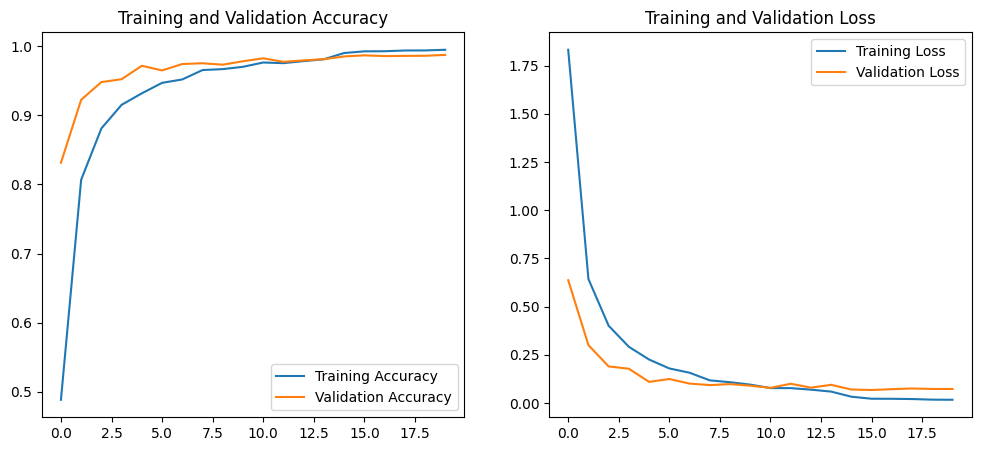

In [36]:
# Plot training curves
plot_training_curves(history_lenet_initial)

####iii. AlexNet Model

In [37]:
# Define Modified AlexNet architecture for (32, 32) input
def create_modified_alexnet(input_shape=(32, 32, 3), num_classes=43):
    model = Sequential([
        Input(shape=input_shape),  # ✅ Fix warning by defining Input separately

        Conv2D(48, kernel_size=(5, 5), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

        Conv2D(192, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(192, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

        Flatten(),
        Dense(1024, activation='relu'),
        Dropout(0.5),
        Dense(1024, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Create and summarize the model
modified_alexnet_model = create_modified_alexnet()
modified_alexnet_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 48)          │           3,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 16, 16, 48)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 16, 16, 128)         │          55,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 8, 8, 192)           │         221,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 8, 8, 192)           │         331,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 8, 8, 128)           │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 43)                  │          44,075 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,025,579 (15.36 MB)

 Trainable params: 4,025,579 (15.36 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
# Define callbacks for early stopping and learning rate reduction
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model with original data
history_modified_alexnet_initial = modified_alexnet_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 332s 420ms/step - accuracy: 0.1445 - loss: 3.1029 - val_accuracy: 0.6849 - val_loss: 0.9705 - learning_rate: 0.0010
Epoch 2/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 318s 405ms/step - accuracy: 0.7539 - loss: 0.7706 - val_accuracy: 0.9176 - val_loss: 0.2762 - learning_rate: 0.0010
Epoch 3/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 342s 436ms/step - accuracy: 0.9041 - loss: 0.3096 - val_accuracy: 0.9525 - val_loss: 0.1649 - learning_rate: 0.0010
Epoch 4/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 362s 410ms/step - accuracy: 0.9460 - loss: 0.1743 - val_accuracy: 0.9688 - val_loss: 0.1009 - learning_rate: 0.0010
Epoch 5/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 376s 403ms/step - accuracy: 0.9585 - loss: 0.1367 - val_accuracy: 0.9653 - val_loss: 0.1223 - learning_rate: 0.0010
Epoch 6/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 323s 412ms/step - accuracy: 0.9614 - loss: 0.1278 - val_accuracy: 0.9689 - val_loss: 0.1099 - learning_rate: 0.0010
Epoch 7/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 380s 410ms/step - accura

#####Saving AlexNet model

In [40]:
modified_alexnet_model.save('/content/Models/alexnet_model.h5')
print("Model saved at: /content/alexnet_model.h5")

Model saved at: /content/alexnet_model.h5


#####Evaluating AlexNet Model

In [41]:
#Evaluate the Model
evaluate_model(modified_alexnet_model, X_val, y_val)

197/197 ━━━━━━━━━━━━━━━━━━━━ 20s 100ms/step - accuracy: 0.9897 - loss: 0.0359
197/197 ━━━━━━━━━━━━━━━━━━━━ 20s 99ms/step
Classification Report:
               precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        35
           1     0.9836    0.9863    0.9849       364
           2     0.9942    0.9857    0.9899       349
           3     0.9955    0.9911    0.9933       225
           4     0.9901    0.9934    0.9918       303
           5     0.9863    0.9931    0.9897       290
           6     1.0000    1.0000    1.0000        71
           7     0.9831    0.9789    0.9810       237
           8     0.9861    0.9861    0.9861       216
           9     1.0000    0.9953    0.9977       214
          10     0.9968    1.0000    0.9984       310
          11     0.9907    0.9953    0.9930       215
          12     1.0000    0.9939    0.9969       326
          13     1.0000    1.0000    1.0000       378
          14     1.0000    1.0000    1.0000 

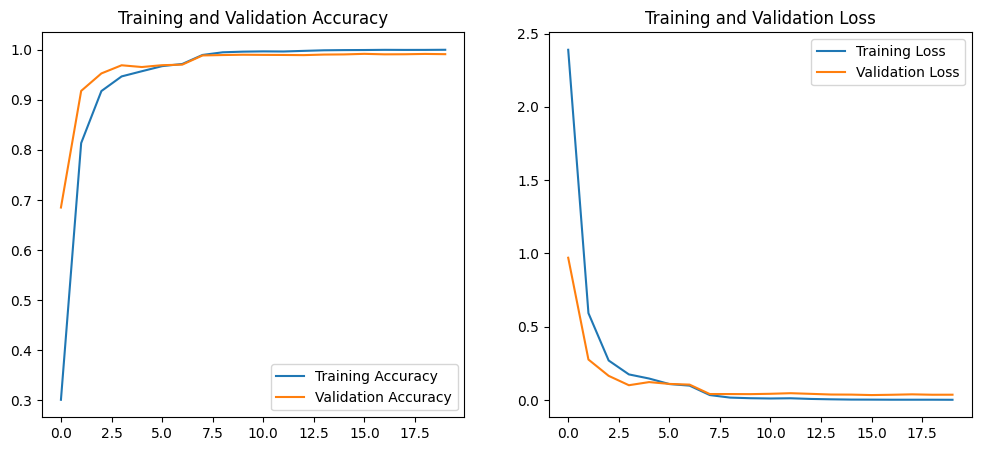

In [42]:
# Plot training curves
plot_training_curves(history_modified_alexnet_initial)

####Retrieving the Highest Validation Accuracy from Training Logs

In [43]:
# Extract best validation accuracy from each model's history
best_val_acc_cnn_aug = max(history_2.history['val_accuracy'])
best_val_acc_lenet = max(history_lenet_initial.history['val_accuracy'])
best_val_acc_modified_alexnet = max(history_modified_alexnet_initial.history['val_accuracy'])

In [44]:
# Create a DataFrame to compare models
comparison_data = {
    "Model": [
        "CNN with Augmentation",
        "LeNet",
        "AlexNet"
    ],
    "Best Val Accuracy": [
        best_val_acc_cnn_aug,
        best_val_acc_lenet,
        best_val_acc_modified_alexnet
    ]
}

# Convert to DataFrame
comparison_df = pd.DataFrame(comparison_data)

# Display the comparison table
print(comparison_df)

                   Model  Best Val Accuracy
0  CNN with Augmentation           0.990277
1                  LeNet           0.987727
2                AlexNet           0.991552


##Validation accuracy of models

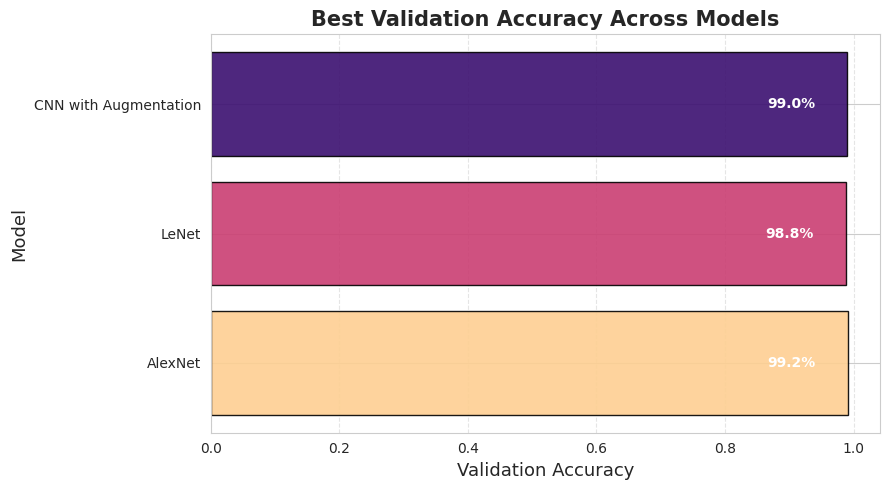

In [45]:
sns.set_style("whitegrid")

# Extract data
models = comparison_df["Model"]
best_val_accs = comparison_df["Best Val Accuracy"]

# Define a color map for the bars
colors = plt.cm.magma(np.linspace(0.2, 0.9, len(models)))

# Create the figure
plt.figure(figsize=(9, 5))
bars = plt.barh(models, best_val_accs, color=colors, edgecolor='black', alpha=0.9)

# Add labels inside bars for better readability
for bar in bars:
    width = bar.get_width()
    plt.text(width - 0.05, bar.get_y() + bar.get_height() / 2,
             f'{width * 100:.1f}%',
             ha='right', va='center', fontsize=10, color='white', fontweight='bold')

# Add title and labels
plt.title('Best Validation Accuracy Across Models', fontsize=15, fontweight='bold')
plt.xlabel('Validation Accuracy', fontsize=13)
plt.ylabel('Model', fontsize=13)

# Invert y-axis for a natural top-down order
plt.gca().invert_yaxis()

# Add grid for better readability
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

##Model accuracy using Test.csv


Evaluating Models on Test Set:

CNN with Augmentation
Test Accuracy: 96.90%

LeNet Model
Test Accuracy: 94.11%

AlexNet Model
Test Accuracy: 95.27%


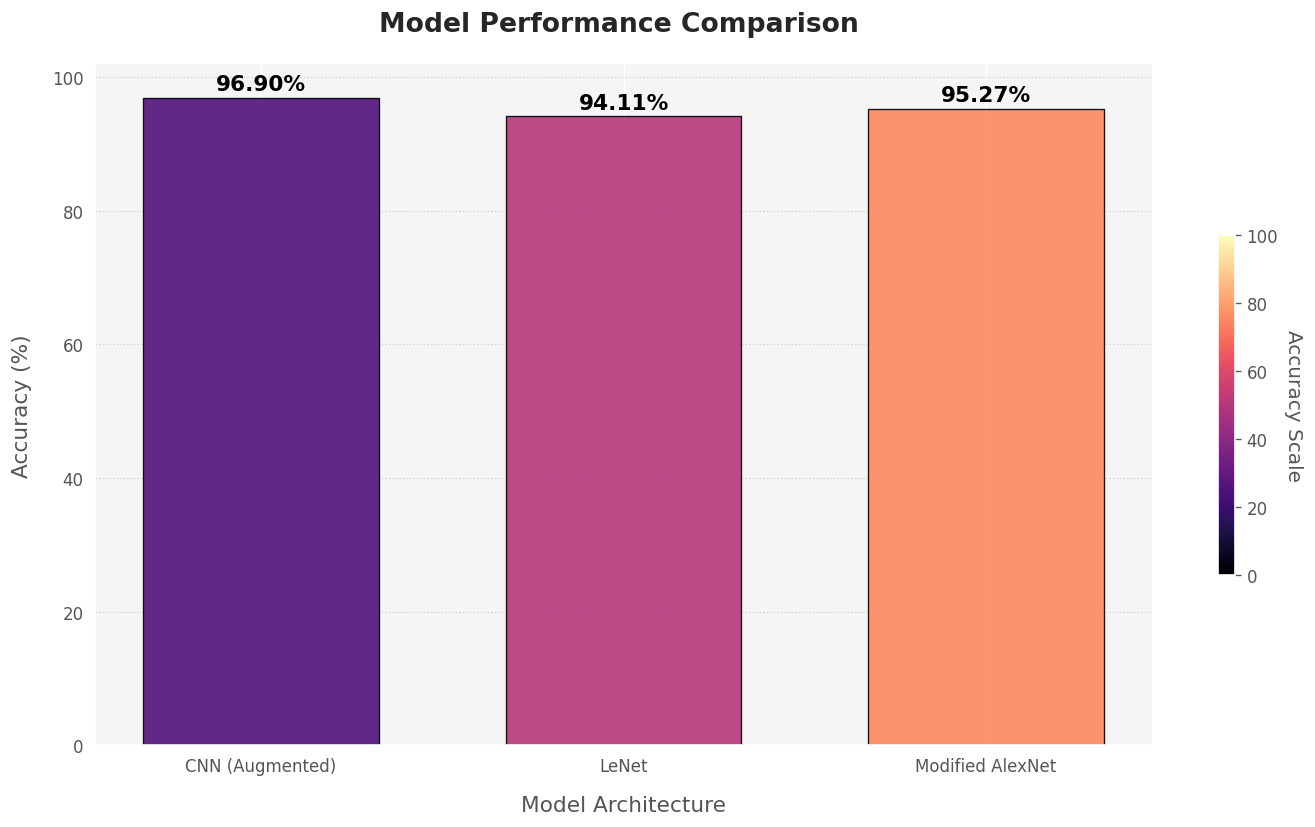

In [46]:
# Define paths
test_csv_path = '/root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1'
metadata_file = os.path.join(test_csv_path, "Test.csv")
test_images_folder = test_csv_path  # Images are in the same directory as the CSV file

def load_and_preprocess_data():
    metadata = pd.read_csv(metadata_file)
    X_test, y_test = [], []

    for _, row in metadata.iterrows():
        img_path = os.path.join(test_images_folder, row['Path'])  # Path to the image
        img = cv2.imread(img_path)

        if img is None:
            print(f"Warning: Could not load image {img_path}")
            continue

        img = cv2.resize(img, (32, 32))  # Resize the image to 32x32
        img = img.astype('float32') / 255.0  # Normalize pixel values to [0, 1]
        X_test.append(img)
        y_test.append(row['ClassId'])  # Assuming 'ClassId' is the column with the labels

    X_test = np.array(X_test)
    y_test = to_categorical(np.array(y_test), num_classes=43)  # One-hot encoding for 43 classes
    return X_test, y_test

def evaluate_models(X_test, y_test):
    print("\n\033[1mEvaluating Models on Test Set:\033[0m")
    print("="*50)

    results = {}

    # CNN with Augmentation
    test_loss_cnn, test_acc_cnn = cnn_aug.evaluate(X_test, y_test, verbose=0)
    results['CNN (Augmented)'] = test_acc_cnn * 100
    print(f"\n\033[1mCNN with Augmentation\033[0m")
    print(f"Test Accuracy: \033[1;34m{test_acc_cnn * 100:.2f}%\033[0m")

    # LeNet
    test_loss_lenet, test_acc_lenet = lenet_model.evaluate(X_test, y_test, verbose=0)
    results['LeNet'] = test_acc_lenet * 100
    print(f"\n\033[1mLeNet Model\033[0m")
    print(f"Test Accuracy: \033[1;32m{test_acc_lenet * 100:.2f}%\033[0m")

    # Modified AlexNet
    test_loss_alexnet, test_acc_alexnet = modified_alexnet_model.evaluate(X_test, y_test, verbose=0)
    results['Modified AlexNet'] = test_acc_alexnet * 100
    print(f"\n\033[1mAlexNet Model\033[0m")
    print(f"Test Accuracy: \033[1;31m{test_acc_alexnet * 100:.2f}%\033[0m")

    return results

def create_visualization(results):

    plt.style.use('ggplot')  # Using reliable built-in style

    fig, ax = plt.subplots(figsize=(12, 7), dpi=120)

    models = list(results.keys())
    accuracies = list(results.values())

    # Three best colors from magma colormap (light to dark)
    magma_colors = [
        plt.cm.magma(0.25),  # Bright pinkish-purple
        plt.cm.magma(0.5),   # Orange-red
        plt.cm.magma(0.75)   # Deep purple
    ]

    # Create bars with these colors
    bars = ax.bar(models, accuracies, color=magma_colors,
                 edgecolor='black', linewidth=0.8,
                 alpha=0.9, width=0.65)

    # Add value labels with contrasting text color
    for i, (model, acc) in enumerate(results.items()):
        text_color = 'black' if i > 0 else 'black'  # Darker first bar needs light text
        ax.text(i, acc + 0.5, f'{acc:.2f}%',
                ha='center', va='bottom',
                fontsize=13, fontweight='bold',
                color=text_color)

    # Customize plot
    ax.set_title('Model Performance Comparison ',
                fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Model Architecture', fontsize=13, labelpad=12)
    ax.set_ylabel('Accuracy (%)', fontsize=13, labelpad=12)
    ax.set_ylim(0, max(accuracies) + 5)

    # Add subtle grid
    ax.yaxis.grid(True, linestyle=':', alpha=0.3, color='gray')

    # Clean up spines
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    # Set background colors
    ax.set_facecolor('#f5f5f5')
    fig.patch.set_facecolor('white')

    # Add colorbar legend to show magma scale
    sm = plt.cm.ScalarMappable(cmap='magma', norm=plt.Normalize(vmin=0, vmax=100))
    sm.set_array([])  # Empty array for colorbar
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', shrink=0.5)
    cbar.set_label('Accuracy Scale', rotation=270, labelpad=15)

    plt.tight_layout()
    plt.savefig('model_accuracy_magma_comparison.png', dpi=300,
               bbox_inches='tight', facecolor='white')
    plt.show()

# Main execution
if __name__ == "__main__":
    try:
        X_test, y_test = load_and_preprocess_data()
        results = evaluate_models(X_test, y_test)
        create_visualization(results)
    except Exception as e:
        print(f"\n\033[1;31mError occurred: {str(e)}\033[0m")


##Final Model Testing

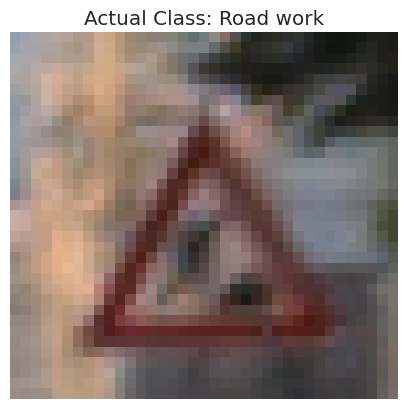

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
CNN with Augmentation Prediction: Road work (Confidence: 1.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
LeNet Prediction: Road work (Confidence: 1.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
AlexNet Prediction: Road work (Confidence: 1.00)


In [51]:
# Actual class labels for the dataset
class_labels = {
    0: 'Speed limit (20km/h)', 1: 'Speed limit (30km/h)', 2: 'Speed limit (50km/h)',
    3: 'Speed limit (60km/h)', 4: 'Speed limit (70km/h)', 5: 'Speed limit (80km/h)',
    6: 'End of speed limit (80km/h)', 7: 'Speed limit (100km/h)', 8: 'Speed limit (120km/h)',
    9: 'No passing', 10: 'No passing vehicles over 3.5 tons', 11: 'Right-of-way at intersection',
    12: 'Priority road', 13: 'Yield', 14: 'Stop', 15: 'No vehicles',
    16: 'Vehicles > 3.5 tons prohibited', 17: 'No entry', 18: 'General caution',
    19: 'Dangerous curve left', 20: 'Dangerous curve right', 21: 'Double curve',
    22: 'Bumpy road', 23: 'Slippery road', 24: 'Road narrows on the right',
    25: 'Road work', 26: 'Traffic signals', 27: 'Pedestrians',
    28: 'Children crossing', 29: 'Bicycles crossing', 30: 'Beware of ice/snow',
    31: 'Wild animals crossing', 32: 'End speed + passing limits',
    33: 'Turn right ahead', 34: 'Turn left ahead', 35: 'Ahead only',
    36: 'Go straight or right', 37: 'Go straight or left', 38: 'Keep right',
    39: 'Keep left', 40: 'Roundabout mandatory', 41: 'End of no passing',
    42: 'End no passing vehicles > 3.5 tons'
}

def preprocess_image(image_path, target_size=(32, 32)):
    """Loads an image, converts it to RGB, resizes, normalizes, and reshapes it for model input."""
    image = cv2.imread(image_path)  # Load the image
    if image is None:
        raise ValueError("Error: Image not found or incorrect path!")

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR (OpenCV) to RGB
    image = cv2.resize(image, target_size)  # Resize to match model input
    image = image.astype("float32") / 255.0  # Normalize pixel values (0-1)
    image = np.expand_dims(image, axis=0)  # Add batch dimension (1, 32, 32, 3)
    return image

def predict_single_image(image_path, models, model_names):
    """Tests a single image on multiple models and prints their predictions with class names."""
    image = preprocess_image(image_path)

    # Get predictions from all models
    for model, name in zip(models, model_names):
        pred = model.predict(image)  # Get model prediction
        predicted_class = np.argmax(pred)  # Get the class with highest probability
        confidence = np.max(pred)  # Get confidence score

        # Get the class name
        class_name = class_labels.get(predicted_class, "Unknown Class")

        print(f"{name} Prediction: {class_name} (Confidence: {confidence:.2f})")

# Select one random image from the test dataset
random_index = random.randint(0, len(df) - 1)
img_path = os.path.join(DATA_PATH, df.iloc[random_index]['Path'])
actual_label = df.iloc[random_index]['ClassId']

# Load and display the randomly selected image
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.title(f"Actual Class: {class_labels.get(actual_label, 'Unknown')}")
plt.axis("off")
plt.show()

# Load the trained models
cnn_aug_model = cnn_aug  # CNN with Augmentation
lenet_model = lenet_model  # LeNet Model
alexnet_model = modified_alexnet_model  # AlexNet Model

# Define models and their names
models = [cnn_aug_model, lenet_model, alexnet_model]
model_names = ["CNN with Augmentation", "LeNet", "AlexNet"]

# Perform prediction on the selected image
predict_single_image(img_path, models, model_names)